Load the needed libraries

In [1]:
# Disulfide Bond Analysis
# Author: Eric G. Suchanek, PhD.
# Cα Cβ Sγ

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
from Bio.PDB import *

import proteusPy
from proteusPy.disulfide import *


from proteusPy import proteusGlobals, Disulfide, DisulfideLoader # classes
# from proteusPy.disulfide import DisulfideExtractor

PDB = '/Users/egs/PDB/'
MODELS = f'{PDB}models/'



# Analysis of Disulfide Bonds in Proteins Within the RCSB Protein Data Bank
*Eric G. Suchanek, PhD. (suchanek@mac.com)* <br> <br>
I describe the results of a structural analysis of Disulfide bonds contained in 36,362 proteins containing 294,478 Disulfide Bonds within the RCSB Protein databank, https://www.rcsb.org. The analysis utilizes Python routines from my ``ProteusPy`` package https://github.com/myml/, which is built upon the excellent ``BioPython`` library (https://www.biopython.org). This work is a reprise of my original Disulfide modeling analysis conducted in 1984 (grab my citation). Given the original Disulfide database only 2xx Disulfide Bonds I felt it would be interesting to revisit the RCSB. The initial results are described in the cells below.

NB: I extended  ``Biopython.PDB.PDBParser()`` class to parse the ``SSBOND`` records present in the RCSB structure files. As of this writing these changes have not been integrated into the official ``Biopython.PDB`` module. Contact me for more info.



## Introduction
Disulfide bonds are important protein structure stabilizing elements. They are formed when two Sulphur-containing Cysteine (Cys) residues are close enough and in the correct geometry to form a S-S covalent bond with their terminal sidechain Sγ atom. They most commonly occur between alpha helices and greatly enhance a protein's stability to denaturation.

In [2]:
from proteusPy.disulfide import *


## Download PDB Files containing Disulfide bonds

In [ ]:

DownloadDisulfides(pdb_home=PDB, model_home=MODELS, reset=False)


## Extract the Disulfides from the PDB files
The function ``Disulfide.DisulfideExtractor()`` processes all the .ent files in ``PDB_DIR`` and creates two .pkl files representing the Disulfide bonds contained in the scanned directory. In addition, a .csv file containing problem IDs is written if any are found. The .pkl files are consumed by the ``DisulfideLoader`` class and are considered private. You'll see numerous warnings during the scan. Files that are unparsable are removed and their IDs are logged to the problem_id.csv file. The default file locations are stored in the file globals.py and are the used by ``DisulfideExtractor()`` in the absence of arguments passed. The Disulfide parser is very stringent and will reject disulfide bonds with missing atoms or disordered atoms.

A full scan of the initial disulfide bond-containing files (> 36000 files) takes about 1.25 hours on a 2020 MacbookPro with M1 Pro chip. The resulting .pkl files consume approximately 1GB of disk space, and equivalent RAM used when loaded.

Outputs are saved in ``MODEL_DIR``:
1) ``SS_PICKLE_FILE``: The ``DisulfideList`` of ``Disulfide`` objects initialized from the PDB file scan, needed by the ``DisulfideLoader()`` class.
2) ``SS_DICT_PICKLE_FILE``: the ``Dict Disulfide`` objects also needed by the ``DisulfideLoader()`` class
3) ``PROBLEM_ID_FILE``: a .csv containining the problem ids.

In general, the process only needs to be run once for a full scan. Setting the ``numb`` argument to -1 scans the entire directory. Entering a positive number allows parsing a subset of the dataset, which is useful when debugging. Setting ``verbose`` enables verbose messages. Setting ``quiet`` to ``True`` disables all warnings.


In [4]:


DisulfideExtractor(numb=110, pdbdir=PDB, modeldir=MODELS, verbose=False, quiet=True)


100%|█████████████████████████████████████████████| 110/110 [00:06<00:00, 16.80it/s, ID=1ayo, Bad=0]


Saving 625 Disulfides to file: /Users/egs/PDB/models/PDB_all_ss.pkl
Saving 110 Disulfide-containing PDB IDs to file: /Users/egs/PDB/models/PDB_all_ss_dict.pkl
Saving torsions to file: /Users/egs/PDB/models/PDB_SS_torsions.csv
Disulfide Extraction complete! Elapsed time: 0:00:06.628076 (h:m:s)


## Load the Disulfide Data
Now that the Disulfides have been extracted and the Disulfide .pkl files have been created we can load them into memory using the DisulfideLoader() class. This class stores the Disulfides internally as a DisulfideList and a dict. Array indexing operations including slicing have been overloaded, enabling straightforward access to the Disulfide bonds, both in aggregate and by residue. After loading the .pkl files the Class creates a Pandas ``DataFrame`` object consisting of the disulfide ID, all sidechain dihedral angles, and the computed Disulfide bond torsional energy.

In [7]:

PDB_SS = DisulfideLoader(verbose=True, modeldir=MODELS)




Reading disulfides from: /Users/egs/PDB/models/PDB_all_ss.pkl
Disulfides Read: 625
Reading disulfide dict from: /Users/egs/PDB/models/PDB_all_ss_dict.pkl
Reading Torsion DF /Users/egs/PDB/models/PDB_SS_torsions.csv.
Read torsions DF.
PDB IDs parsed: 110
Total Space Used: 137381 bytes.


## Examine the Disulfide Torsions
The Disulfide dihedral angles $\chi_{1}$-$\chi_{5}$ along with their approximate torsional energy are stored in the DataLoader() class.

In [8]:
SS_df = pd.DataFrame()

SS_df = PDB_SS.getTorsions() # retrieve the torsions dataframe
SS_df[['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'energy']].describe()

,chi1,chi2,chi3,chi4,chi5,energy
count,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000
mean,-60.359229,-21.089653,-10.503387,-20.999120,-42.211066,3.589694
std,90.910404,100.884843,92.628471,110.450809,93.012098,2.485300
min,-179.573310,-179.692959,-168.074863,-179.064003,-179.782633,0.575261
25%,-108.779775,-87.697088,-88.406946,-93.470473,-77.365378,1.858745
50%,-64.708946,-61.780977,-73.828005,-65.621226,-61.150583,3.033137
75%,-52.500311,74.497538,90.194186,81.848751,-28.882373,4.392322
max,179.401882,179.315825,173.745213,179.462454,179.883387,15.280323


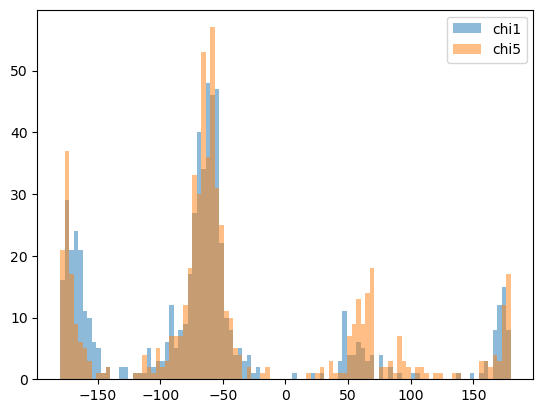

In [9]:
import numpy
from matplotlib import pyplot

bins = numpy.linspace(-180, 180, 100)
chi1_data = SS_df['chi1']
chi2_data = SS_df['chi2']
chi3_data = SS_df['chi3']
chi4_data = SS_df['chi4']
chi5_data = SS_df['chi5']

pyplot.hist(chi1_data, bins, alpha=0.5, label='chi1')
pyplot.hist(chi5_data, bins, alpha=0.5, label='chi5')

pyplot.legend(loc='upper right')
pyplot.show()


In [ ]:
pyplot.hist(chi2_data, bins, alpha=0.5, label='chi2')
pyplot.hist(chi4_data, bins, alpha=0.5, label='chi4')
pyplot.legend(loc='upper right')
pyplot.show()



In [ ]:
pyplot.hist(chi3_data, bins, alpha=0.5, label='chi3')
pyplot.legend(loc='upper right')
pyplot.show()

